Сгенерировал 20000 строк данных с логами использования youtube. Датасет включает информацию о пользователях, времени взаимодейтсвия, категорях видео и продолжительности просмотра в секундах.

In [11]:
import pandas as pd
import random
from datetime import datetime, timedelta

def generate_youtube_logs(num_rows=20000):
    random.seed(42)
    user_ids = [f"user_{random.randint(1000, 9999)}" for _ in range(500)]  # 500 уникальных пользователей
    video_ids = [f"video_{random.randint(100000, 999999)}" for _ in range(300)]  # 300 уникальных видео
    categories = ["Music", "Gaming", "Education", "Comedy", "News", "Sports", "Travel", "Lifestyle"]
    devices = ["Web", "Android", "iOS", "Smart TV"]   
    start_date = datetime(2022, 1, 1)
    
    data = []
    for _ in range(num_rows):
        user_id = random.choice(user_ids)
        video_id = random.choice(video_ids)
        category = random.choice(categories)
        device = random.choice(devices)
        timestamp = start_date + timedelta(seconds=random.randint(0, 31536000))
        watch_duration = random.randint(1, 3000)
        data.append([user_id, timestamp.strftime("%Y-%m-%d %H:%M:%S"), video_id, category, device, watch_duration])
    columns = ["user_id", "timestamp", "video_id", "category", "device", "watch_duration"]
    df = pd.DataFrame(data, columns=columns)
    return df

youtube_logs = generate_youtube_logs(20000)
youtube_logs.to_csv("youtube_usage_logs.csv", index=False)


In [12]:
youtube_logs.head()

,user_id,timestamp,video_id,category,device,watch_duration
0,user_4946,2022-03-30 08:17:48,video_609232,Comedy,iOS,1479
1,user_5304,2022-04-17 12:46:00,video_831059,Music,Android,187
2,user_5451,2022-09-05 17:22:33,video_998348,News,Android,2011
3,user_4814,2022-07-05 21:56:23,video_501641,News,Smart TV,1805
4,user_1117,2022-12-01 15:50:24,video_185884,Music,iOS,1957


In [13]:
segment_web = youtube_logs[youtube_logs['device'] == 'Web']
segment_android = youtube_logs[youtube_logs['device'] == 'Android']
segment_ios = youtube_logs[youtube_logs['device'] == 'iOS']
segment_smart_tv = youtube_logs[youtube_logs['device'] == 'Smart TV']

Разбил пользователей на 4 сегманта и посмтроил к каждому сегменту гистограмму, на которой отображено количество пользователей для различных диапазонов времени просмотра контента, чтобы я понимал с чем работаю



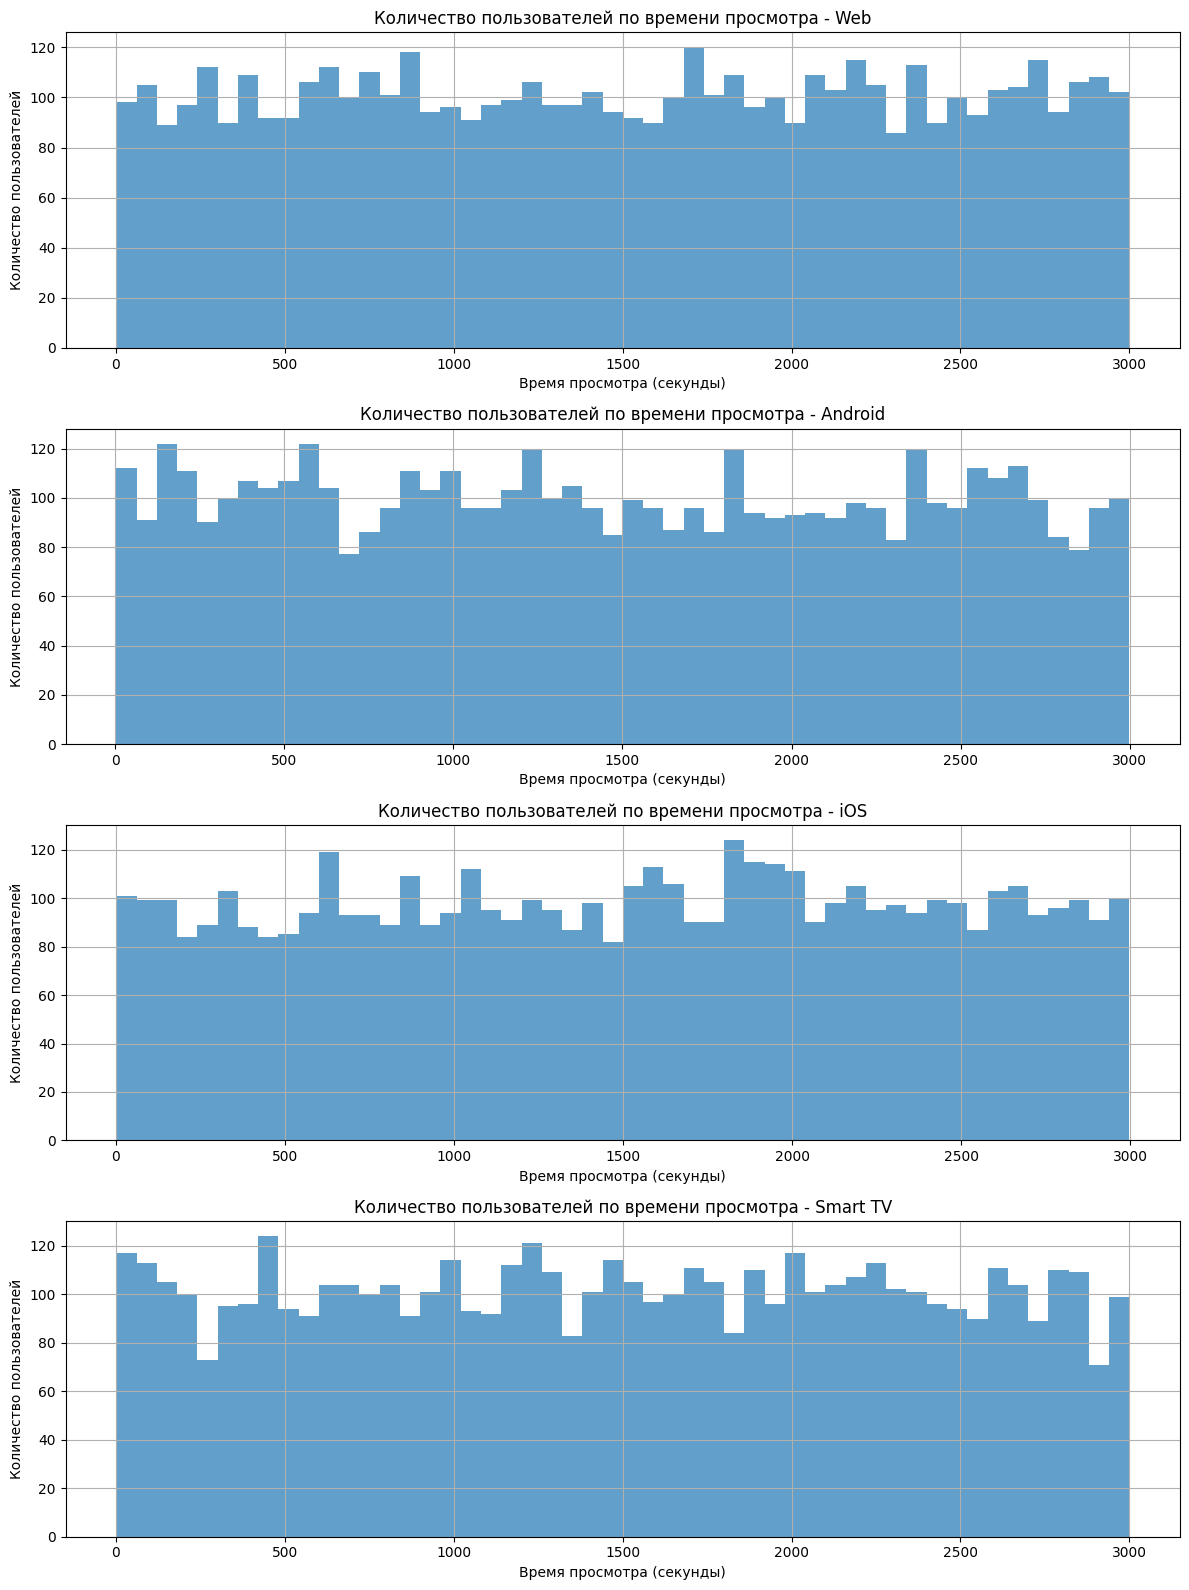

In [16]:
import matplotlib.pyplot as plt

segments = {
    "Web": segment_web["watch_duration"],
    "Android": segment_android["watch_duration"],
    "iOS": segment_ios["watch_duration"],
    "Smart TV": segment_smart_tv["watch_duration"]
}


plt.figure(figsize=(12, 16))

for i, (segment_name, durations) in enumerate(segments.items(), 1):
    plt.subplot(4, 1, i)
    plt.hist(durations, bins=50, alpha=0.7)
    plt.title(f"Количество пользователей по времени просмотра - {segment_name}")
    plt.xlabel("Время просмотра (секунды)")
    plt.ylabel("Количество пользователей")
    plt.grid(True)


plt.tight_layout()
plt.show()


In [21]:
from scipy import stats
import numpy as np
metrics = {
    "watch_duration": "Продолжительность просмотра (сек)",
    "timestamp": "Распределение времени",
}

youtube_logs["timestamp_numeric"] = pd.to_datetime(youtube_logs["timestamp"]).astype(np.int64) / 10 ** 9

ttest_result = stats.ttest_ind(segment_web["watch_duration"], segment_android["watch_duration"], equal_var=False)

mannwhitney_result = stats.mannwhitneyu(segment_ios["watch_duration"], segment_smart_tv["watch_duration"])

anova_result = stats.f_oneway(segment_web["watch_duration"], segment_android["watch_duration"], segment_ios["watch_duration"], segment_smart_tv["watch_duration"])

results = {
    "T-test (Web vs Android)": ttest_result.pvalue,
    "Mann-Whitney U-test (iOS vs Smart TV)": mannwhitney_result.pvalue,
    "ANOVA F-test (all segments)": anova_result.pvalue
}

results_summary = {}

for test_name, pval in results.items():
    print(f"test_name: {test_name}, pval: {pval}")
    if pval < 0.05:
        results_summary[test_name] = "Значимо отличается"
    else:
        results_summary[test_name] = "Нет значимого различия"
results_summary

test_name: T-test (Web vs Android), pval: 0.09889947857190157
test_name: Mann-Whitney U-test (iOS vs Smart TV), pval: 0.26170380739347476
test_name: ANOVA F-test (all segments), pval: 0.2028497131446596


{'T-test (Web vs Android)': 'Нет значимого различия',
 'Mann-Whitney U-test (iOS vs Smart TV)': 'Нет значимого различия',
 'ANOVA F-test (all segments)': 'Нет значимого различия'}

Мною были сделаны выводы, что независимо от типа устройства, пользователи примерно одинаково пользуються площадкой по времени просмтора видео. К тому же похую картину мы могли видеть на гистограммах.

In [22]:
segment_names = list(segments.keys())
pairwise_ttest_results = {}
anova_results = {}

for i in range(len(segment_names)):
    for j in range(i + 1, len(segment_names)):
        segment_1 = segments[segment_names[i]]
        segment_2 = segments[segment_names[j]]
        ttest_res = stats.ttest_ind(segment_1, segment_2, equal_var=False).pvalue
        pairwise_ttest_results[f"{segment_names[i]} vs {segment_names[j]}"] = ttest_res

anova_res = stats.f_oneway(segments["Web"], segments["Android"], segments["iOS"], segments["Smart TV"]).pvalue
anova_results["ANOVA F-test (all segments)"] = anova_res

comparison_results = {}
for pair, pval in pairwise_ttest_results.items():
    if (pval < 0.05 and anova_res < 0.05) or (pval >= 0.05 and anova_res >= 0.05):
        comparison_results[pair] = "Совпадает"
    else:
        comparison_results[pair] = "Не совпадает"

comparison_results


{'Web vs Android': 'Совпадает',
 'Web vs iOS': 'Совпадает',
 'Web vs Smart TV': 'Совпадает',
 'Android vs iOS': 'Совпадает',
 'Android vs Smart TV': 'Совпадает',
 'iOS vs Smart TV': 'Совпадает'}

Результаты соотносятся

In [23]:
import numpy as np

def bootstrap_confidence_interval(data, num_bootstrap=1000, confidence_level=0.95):
    bootstrapped_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence_level) / 2 * 100)
    
    return lower_bound, upper_bound

def t_student_confidence_interval(data, confidence_level=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_error = std_err * stats.t.ppf((1 + confidence_level) / 2, n - 1)
    
    lower_bound = mean - margin_error
    upper_bound = mean + margin_error
    
    return lower_bound, upper_bound

web_watch_durations = segment_web["watch_duration"].values

bootstrap_ci = bootstrap_confidence_interval(web_watch_durations)

t_student_ci = t_student_confidence_interval(web_watch_durations)

confidence_intervals = {
    "Bootstrap (Эфронов)": bootstrap_ci,
    "T-Student (точный)": t_student_ci
}

confidence_intervals


{'Bootstrap (Эфронов)': (1483.8690620047544, 1531.7854447305863),
 'T-Student (точный)': (1483.7680800895557, 1531.656642572885)}

Границы доверительных интервалов по методу Эфрона и тесту Стьюдента практически совпадают, что подтверждает консистентность результатов. Это говорит о том, что выборочная средняя продолжительность просмотра в сегменте Web попадает в один и тот же диапазон независимо от подхода.

ПУНКТ 5
Для повышения точности выводов можно применять дополнительные тесты, такие как: Критерий Вилкоксона (альтернатива T-тесту, когда данные не соответствуют нормальному распределению) и Критерий Левена (проверяет, одинаковы ли дисперсии между группами)